In [1]:
#Initial Setup
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from time import process_time
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('dass_modeling.csv')
df.head()

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,voted,married,familysize,major,Depression,Depression_cat,Anxiety,Anxiety_cat,Stress,Stress_cat
0,4,4,2,4,4,4,4,4,2,1,...,2,1,2,No Degree,27,3,34,4,40,4
1,4,1,2,3,4,4,3,4,3,2,...,2,1,4,No Degree,24,3,17,3,27,3
2,3,1,4,1,4,3,1,3,2,4,...,1,1,3,No Degree,39,4,12,2,17,1
3,2,3,2,1,3,3,4,2,3,3,...,2,1,5,Biology,16,2,17,3,16,1
4,2,2,3,4,4,2,4,4,4,3,...,2,1,4,Psychology,32,4,40,4,29,3


In [3]:
df.dtypes.value_counts()

int64     60
object     2
dtype: int64

In [4]:
df['country']=pd.factorize(df['country'], sort=True)[0]+1
df['major']=pd.factorize(df['major'], sort=True)[0]+1

In [5]:
df.dtypes.value_counts()

int64    62
dtype: int64

In [6]:
# Target variable will determine severe depression. Levels 3 or 4 indicates severe depression.  So 1 means the individual has 
# severe depression, while 0 means they do not.

bin_out=[]

for i in df['Depression_cat']:
    if i > 2:
        bin_out.append(1)
    else:
        bin_out.append(0)

df['Outcome']=bin_out

df.head()

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,married,familysize,major,Depression,Depression_cat,Anxiety,Anxiety_cat,Stress,Stress_cat,Outcome
0,4,4,2,4,4,4,4,4,2,1,...,1,2,46,27,3,34,4,40,4,1
1,4,1,2,3,4,4,3,4,3,2,...,1,4,46,24,3,17,3,27,3,1
2,3,1,4,1,4,3,1,3,2,4,...,1,3,46,39,4,12,2,17,1,1
3,2,3,2,1,3,3,4,2,3,3,...,1,5,10,16,2,17,3,16,1,0
4,2,2,3,4,4,2,4,4,4,3,...,1,4,56,32,4,40,4,29,3,1


In [7]:
df.drop(['Depression', 'Depression_cat', 'Anxiety', 'Anxiety_cat', 'Stress', 'Stress_cat'],axis=1,inplace=True)

In [8]:
df.drop(['Q'+str(i)+'A' for i in range(3,43)],axis=1,inplace=True)

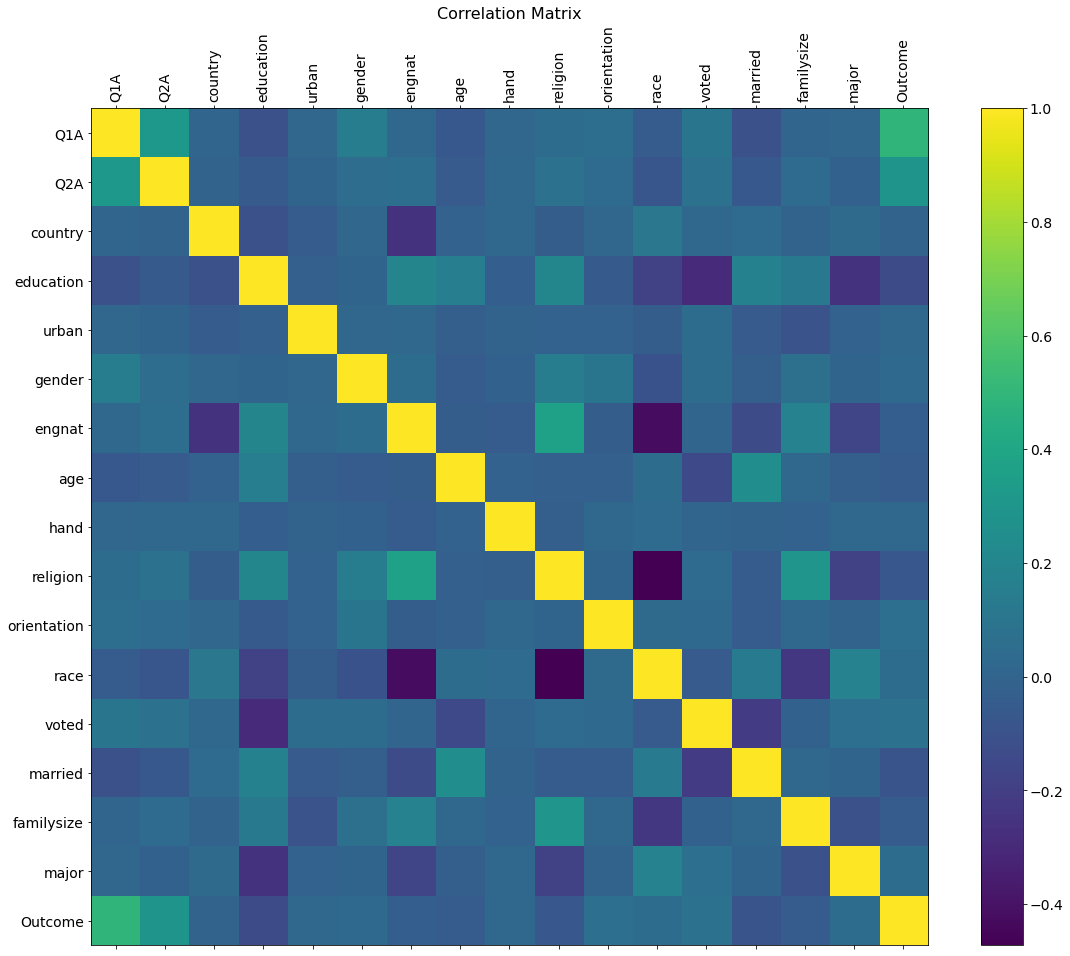

In [9]:
# Drop variables that are not ordinal for the correlation matrix
#cmdf = df.drop(['country','urban','gender','engnat','hand','religion','orientation','race','married','major'],axis=1)
cmdf = df

f = plt.figure(figsize=(19, 15))
plt.matshow(cmdf.corr(), fignum=f.number)
plt.xticks(range(cmdf.select_dtypes(['number']).shape[1]), cmdf.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(cmdf.select_dtypes(['number']).shape[1]), cmdf.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [10]:
# PCA with only 2 Principal Components first, and visualization

#Scale the data
scaler = StandardScaler()
scaled=scaler.fit_transform(df)

In [11]:
#Obtain principal components
pca = PCA().fit_transform(scaled)

pc1 = pca[:,0]
pc2 = pca[:,1]

Text(0, 0.5, 'PC2')

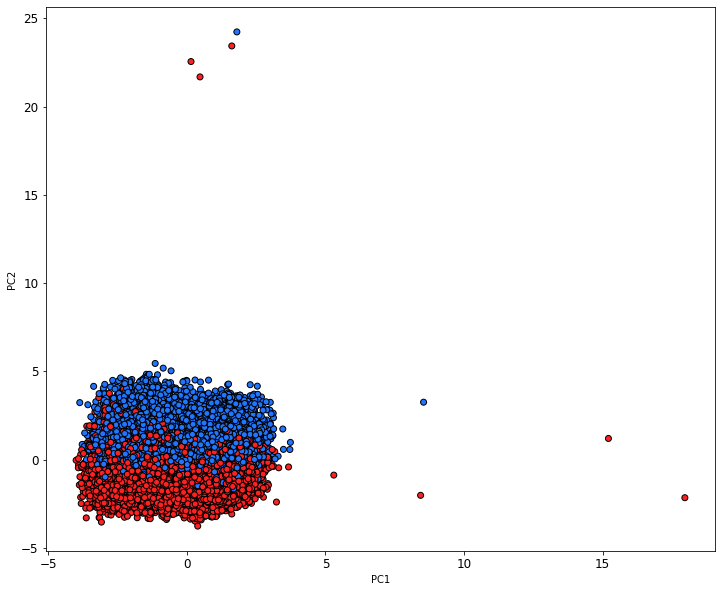

In [12]:
#Plot principal components
plt.figure(figsize=(12,10))

colour = ['#ff2121' if y == 1 else '#2176ff' for y in df['Outcome']]
plt.scatter(pc1,pc2 ,c=colour,edgecolors='#000000')
plt.yticks(size=12)
plt.xticks(size=12)
plt.xlabel('PC1')
plt.ylabel('PC2')

In [13]:
#Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Outcome',axis=1))
y = df['Outcome'].values.reshape(-1,1)

# 95% of variance
pca = PCA(n_components = 0.95)
pca.fit(X)
reduced_ninety_five = pca.transform(X)
no_comp = reduced_ninety_five.shape[1]
no_comp

15

This shows that 15 components will capture 95% of the variance.

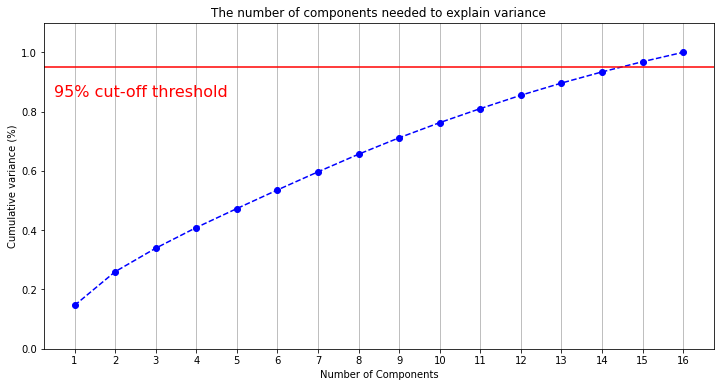

In [14]:
# Visualization for PCA determination of number of components

pca = PCA().fit(X)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 17, step=1)
y_pca = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y_pca, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 17, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [15]:
# Perform PCA again with optimal number of principal components
pca = PCA(n_components = no_comp)
princompX = pca.fit_transform(X)

In [16]:
# Check balance of dataset
unique, counts = np.unique(y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    0 19698]
 [    1 20039]]


In [17]:
# Perform SMOTE on the dataset
resample=SMOTE(random_state=42)

X_res, y_res = resample.fit_resample(princompX,y)

In [18]:
unique, counts = np.unique(y_res, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    0 20039]
 [    1 20039]]


In [19]:
# Create training and test sets to examine DEPRESSION
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [20]:
t1_start = process_time() 

clf = svm.SVC(kernel='linear') 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

t1_stop = process_time()

print ('Processing time = ', t1_stop - t1_start)

Processing time =  59.734375


In [21]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7297904191616766


In [22]:
print("Precision:",metrics.precision_score(y_test, y_pred))

Precision: 0.7386422976501306


In [23]:
print("Recall:",metrics.recall_score(y_test, y_pred))

Recall: 0.7083124687030545


In [24]:
#A function which returns the corresponding SVC model
def getClassifier(ktype):
    if ktype == 1:
        # Polynomial kernel
        return SVC(kernel='poly', degree=8, gamma="auto")
    elif ktype == 2:
        # Radial Basis Function kernel
        return SVC(kernel='rbf', gamma="auto")
    elif ktype == 3:
        # Sigmoid kernel
        return SVC(kernel='sigmoid', gamma="auto")
    elif ktype == 4:
        # Linear kernel
        return SVC(kernel='linear', gamma="auto")

In [30]:
kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']

for i in range(1,5):
    # Separate data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)
    svclassifier = getClassifier(i)
    svclassifier.fit(X_train, y_train.ravel())# Make prediction
    y_pred = svclassifier.predict(X_test)# Evaluate our model
    print("Evaluation:", kernels[i-1], "kernel")
    print(classification_report(y_test,y_pred))

Evaluation: Polynomial kernel
              precision    recall  f1-score   support

           0       0.66      0.78      0.72      3940
           1       0.74      0.60      0.66      4008

    accuracy                           0.69      7948
   macro avg       0.70      0.69      0.69      7948
weighted avg       0.70      0.69      0.69      7948

Evaluation: RBF kernel
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      3940
           1       0.72      0.76      0.74      4008

    accuracy                           0.73      7948
   macro avg       0.73      0.73      0.73      7948
weighted avg       0.73      0.73      0.73      7948

Evaluation: Sigmoid kernel
              precision    recall  f1-score   support

           0       0.63      0.62      0.63      3940
           1       0.63      0.64      0.64      4008

    accuracy                           0.63      7948
   macro avg       0.63      0.63      0.63     

In [31]:
# Apply most performative kernel parameter to param_grid
param_grid = {'C': [0.1,1, 10, 100], 'gamma': ['auto'],'kernel': ['rbf']}

In [ ]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train.ravel())

In [ ]:
print(grid.best_estimator_)

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')